In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
weg = '/media/n01z3/storage3/dataset/carvana/'

In [2]:
from renorm import BatchRenormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import ELU

Using TensorFlow backend.


In [3]:
white = False
image_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    zca_whitening=white)

mask_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    zca_whitening=white)

In [4]:
load_img = lambda im: cv2.imread(join(weg+'train', '{}.jpg'.format(im)))
load_mask = lambda im: imread(join(weg+'train_masks', '{}_mask.gif'.format(im)))
load_mask_gif = lambda im: imread(join(weg+'train_masks', '{}_mask.gif'.format(im)))[:,:,0]

resize = lambda im: downscale_local_mean(im, (4,4) if im.ndim==2 else (4,4,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))
from os.path import join

In [5]:
def batch_gen(size=1,height=160,width=240,aug=True,inter=True,fit=False):
    counter = 0 #счетчик запускам
    global fold_number
    select = df_folds.img.values[df_folds.fold!=fold_number]
    number_of_batches = np.ceil(len(select)/size) #количестов партий - зависит от размера партии
    while 1:



        cc = 0
        x = np.empty((size, height, width, 3), dtype=np.float32) # пустой массив для загрузки картинок
        y = np.empty((size, height, width, 1), dtype=np.float32)
        for img_id in select[size*counter:size*(counter+1)]: #16

            imgs_id = [cv2.resize(load_img(img_id),(width,height))/255.]
            # Input is image + mean image per channel + std image per channel
           
            mask_16 = [cv2.resize(load_mask(img_id), ( width,height))/ 255.]
            try:
                if mask_16[0].shape[2]>1:

                    mask_16 = [cv2.resize(load_mask_gif(img_id), ( width,height))/ 255.]
            except:
                pass
                
            #X[i] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
            
            x[cc:(1+cc)] = np.array(imgs_id)
            y[cc:(1+cc)] = np.expand_dims(np.array(mask_16),3)
            
            cc+=1    
        del imgs_id
        counter+=1
        SEED = int(np.random.randint(0,999999,1))
        if inter == False: #если не чередуем данные
            if aug == True:  # делаем ли аугментацию?
                if fit==True:
                    image_generator.fit(x)
                    mask_generator.fit(y)


                for img in image_generator.flow((x),batch_size=size,seed=SEED):
                    break

                for msk in mask_generator.flow((y),batch_size=size,seed=SEED):
                    break 
                yield(img,msk)

            if aug == False: # или базовую картинку?
                yield(x,y)

        if inter == True: # если чередуем то по очереди загружаем то одно то другое
            if counter % 2 ==0:
                if fit==True:
                    image_generator.fit(x)
                    mask_generator.fit(y)
                for img in image_generator.flow((x),batch_size=size,seed=SEED):
                    break

                for msk in mask_generator.flow((y),batch_size=size,seed=SEED):
                    break 
                yield(img,msk)

            else:
                yield(x,y)
                
        if counter == number_of_batches:
            counter = 0
            np.random.shuffle(select)

In [6]:
def val_gen(size=1,height=160,width=240,aug=True,inter = True,fit=False):
    global fold_number
    select = df_folds.img.values[df_folds.fold==fold_number]
    number_of_batches = np.ceil(len(select)/size) #количестов партий - зависит от размера партии
    counter = 0
    while 1:



        cc = 0
        x = np.empty((size, height, width, 3), dtype=np.float32) # пустой массив для загрузки картинок
        y = np.empty((size, height, width, 1), dtype=np.float32)
        for img_id in select[size*counter:size*(counter+1)]: #16

            imgs_id = [cv2.resize(load_img(img_id),(width,height))/255.]
            # Input is image + mean image per channel + std image per channel
            mask_16 = [cv2.resize(load_mask(img_id), ( width,height))/ 255.]
            try:
                if mask_16[0].shape[2]>1:

                    mask_16 = [cv2.resize(load_mask_gif(img_id), ( width,height))/ 255.]
            except:
                pass
            
            x[cc:(1+cc)] = np.array(imgs_id)
            y[cc:(1+cc)] = np.expand_dims(np.array(mask_16),3)
            
            cc+=1    
        del imgs_id
        counter+=1
        
        SEED = int(np.random.randint(0,999999,1))
        if inter == False: #если не чередуем данные
            if aug == True:  # делаем ли аугментацию?
                if fit==True:
                    image_generator.fit(x)
                    mask_generator.fit(y)


                for img in image_generator.flow((x),batch_size=size,seed=SEED):
                    break
                for msk in mask_generator.flow((y),batch_size=size,seed=SEED):
                    break 
                yield(img,msk)
                #del img,msk
                #del x,y
            if aug == False: # или базовую картинку?
                yield(x,y)
                #del x,y
        if inter == True: # если чередуем то по очереди загружаем то одно то другое
            if counter % 2 ==0:
                if fit==True:
                    image_generator.fit(x)
                    mask_generator.fit(y)
                for img in image_generator.flow((x),batch_size=size,seed=SEED):
                    break
                
                for msk in mask_generator.flow((y),batch_size=size,seed=SEED):
                    break 
                yield(img,msk)
                #del img,msk
                #del x,y
            else:
                yield(x,y)
                #del x,y
        
        if counter == number_of_batches:
            counter = 0
            np.random.shuffle(select)

In [7]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Activation, UpSampling2D
from keras.optimizers import SGD
import keras.backend as K
from skimage.io import imread


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_loss(y_true, y_pred)

def get_unet_1024(input_shape=(1280, 1280, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 512

    down0a = Conv2D(16, (3, 3), padding='same')(inputs)
    down0a = BatchRenormalization()(down0a)
    down0a = ELU()(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = BatchRenormalization()(down0a)
    down0a = ELU()(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = BatchRenormalization()(down0)
    down0 = ELU()(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchRenormalization()(down0)
    down0 = ELU()(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchRenormalization()(down1)
    down1 = ELU()(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchRenormalization()(down1)
    down1 = ELU()(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchRenormalization()(down2)
    down2 = ELU()(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchRenormalization()(down2)
    down2 = ELU()(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchRenormalization()(down3)
    down3 = ELU()(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchRenormalization()(down3)
    down3 = ELU()(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchRenormalization()(down4)
    down4 = ELU()(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchRenormalization()(down4)
    down4 = ELU()(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchRenormalization()(center)
    center = ELU()(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchRenormalization()(center)
    center = ELU()(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchRenormalization()(up4)
    up4 = ELU()(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchRenormalization()(up4)
    up4 = ELU()(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchRenormalization()(up4)
    up4 = ELU()(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchRenormalization()(up3)
    up3 = ELU()(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchRenormalization()(up3)
    up3 = ELU()(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchRenormalization()(up3)
    up3 = ELU()(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchRenormalization()(up2)
    up2 = ELU()(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchRenormalization()(up2)
    up2 = ELU()(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchRenormalization()(up2)
    up2 = ELU()(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchRenormalization()(up1)
    up1 = ELU()(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchRenormalization()(up1)
    up1 = ELU()(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchRenormalization()(up1)
    up1 = ELU()(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchRenormalization()(up0)
    up0 = ELU()(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchRenormalization()(up0)
    up0 = ELU()(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchRenormalization()(up0)
    up0 = ELU()(up0)
    # 256

    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchRenormalization()(up0a)
    up0a = ELU()(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchRenormalization()(up0a)
    up0a = ELU()(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchRenormalization()(up0a)
    up0a = ELU()(up0a)
    # 512

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_loss,'accuracy'])
    #model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss=dice_coef_loss, metrics=[dice_loss,'accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_loss,'accuracy'])
    #model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics=[dice_loss,'accuracy'])
    #SGD(lr=0.01, momentum=0.9)
    return model



In [8]:
model = get_unet_1024()
model.load_weights('unet_new_1280_1280_2_batch_renorm_9_my_gen_ELU.hdf5')

In [9]:
import pandas as pd
import numpy as np

import cv2


from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

df_folds = pd.read_csv(weg+'folds_ready.csv')
df_train = pd.read_csv(weg+'train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

input_size_1 = 1920
input_size_2 = 1280

epochs = 100
batch_size = 1

#ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.1)#, random_state=42)

#print('Training on {} samples'.format(len(ids_train_split)))
#print('Validating on {} samples'.format(len(ids_valid_split)))


def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


def train_generator():
    while True:
        for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for id in ids_train_batch.values:
                img = cv2.imread(weg+'train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size_1, input_size_2))
                mask = imread(weg+'train_masks/{}_mask.gif'.format(id), cv2.IMREAD_GRAYSCALE)
                try:
                    if mask.shape[2]>1:

                        mask = mask[:,:,0]
                except:
                    pass
                mask = cv2.resize(mask, (input_size_1, input_size_2))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


def valid_generator():
    while True:
        for start in range(0, len(ids_valid_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img = cv2.imread(weg+'train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size_1, input_size_2))
                mask = imread(weg+'train_masks/{}_mask.gif'.format(id), cv2.IMREAD_GRAYSCALE)
                try:
                    if mask.shape[2]>1:

                        mask = mask[:,:,0]
                except:
                    pass
                mask = cv2.resize(mask, (input_size_1, input_size_2))
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch



In [10]:
import h5py
from tqdm import tqdm
size_1 = 1280
size_2 = 1280


In [ ]:
    import pandas as pd
    import numpy as np

    import cv2
    from tqdm import tqdm
    threshold = 0.5


    
    df_test = pd.read_csv(weg+'sample_submission.csv')
    ids_test = df_test['img'].map(lambda s: s.split('.')[0])


    orig_width = 1918
    orig_height = 1280

    def _mask_to_rle_string(mask):
        """Convert boolean/`binary uint` mask to RLE string."""
        # Mask to RLE
        pixels = mask.flatten()
        pixels[0] = 0
        pixels[-1] = 0
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
        runs[1::2] = runs[1::2] - runs[:-1:2]

        # RLE to string
        return ' '.join(str(x) for x in runs)

    names = []
    for id in ids_test:
        names.append('{}.jpg'.format(id))


    rles = []

    for id_1 in tqdm(ids_test,miniters=1000):
                

        x0 = np.load(weg+str(0)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.15
        x1 = np.load(weg+str(1)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.05
        x2 = np.load(weg+str(2)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.15
        x3 = np.load(weg+str(3)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.1
        x4 = np.load(weg+str(4)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.22
        
        img = cv2.imread(weg+'test/{}.jpg'.format(id_1))
        img = cv2.resize(img, (x0.shape[0], x0.shape[1]))
        img = img/255.
        img = np.expand_dims(img,0)
        img = model.predict(img)
        img = img[0] *0.33       
        if not os.path.exists(weg+'best_submission'): os.mkdir(weg+'best_submission')    
        
        loaded = x0+x1+x2+x3+x4+img
        np.savez_compressed(weg+'best_submission/' + id_1,loaded)
        
        

 67%|██████▋   | 66937/100064 [12:38:37<7:05:05,  1.30it/s] 

In [ ]:
df_test = pd.read_csv(weg+'sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])
for fold in [0,1]:
    print ('FOLD ' + str(fold))
    model = get_unet_1024()
    model.load_weights(str(fold)+'_fold_1280_1280_ElU_renorm.hdf5')
    for test_id in tqdm(ids_test.values,miniters=1000):
        if not os.path.exists(weg+'best_submission'): os.mkdir(weg+'best_submission')
        test_img =  cv2.resize(cv2.imread(weg+'test/{}.jpg'.format(test_id)),(size_1,size_2))/255.
        test_img = np.expand_dims(test_img,0)
        pred = model.predict(test_img)[0]
        np.savez_compressed(weg+str(fold)+'_fold_test_predicted/' + test_id,pred)
    print ('Saved for fold '+ str(fold))
    del model

In [ ]:
img = img[0] *0.33         
x0 = np.load(weg+str(0)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.15         
x1 = np.load(weg+str(1)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.05         
x2 = np.load(weg+str(2)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.15         
x3 = np.load(weg+str(3)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.1         
x4 = np.load(weg+str(4)+'_fold_test_predicted/' + str(id_1)+'.npz')['arr_0']*0.22

In [17]:
from matplotlib import pyplot as plt

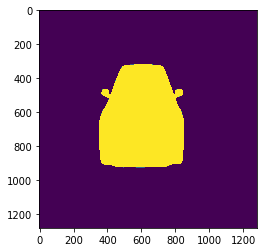

In [26]:
plt.imshow(np.squeeze(loaded))
plt.show()